# Histograma Puntos Visitante

### ETL

Start Date: 11/11/2019

End Date:   29/12/2019

### José María Álvarez Silva


## 1. Describe brevemente que diferencia el persists, cache y collect en spark. Explica brevemente casos en los que es interesante su aplicación.

* __Respuesta:__ 

 1. `cache( )`: utiliza en nivel de almacenamiento standar (i.e. almacena un RDD en la memoria y un dataset en memoria y disco.
 2. `persist( )`: se especifica el nivel de almacenamiento tanto para RDD como para datasets. 
 3. `collect( )`: regresa todos los objeto de un RDD en forma de lista.

## 2. Explica brevemente los pasos a seguir para realizar la carga de un conjunto de datos (pasos que se siguieron en la práctica con datos de logs).

* __Respuesta:__ 

 1. Cargar el archivo de los datos con la función textFile( ) de pyspark.
 2. Contar el número de observaciones del dataset para entender la magnitud de los datos con los que trabajaremos para tener cuidado ha ejecutar acciones.
 3. Observar la estructura de los datos mirando directamente el archivo o utilizando la función take( ) de pyspark.
 4. Teniendo el cuenta la estructura de los datos, realizar un parseo con expresiones regulares para evitar capturar datos o headers que no queremos incluir en el análisis.

## 3. Índica un tipo de problema que puede empeorar los datos. (pe. Que no exista un representante del CDO en todas las áreas de negocio), pon algún ejemplo específico (pe. Datos duplicados) y cómo lo tratarías con técnicas de data cleaning.

* __Respuesta:__ 

 * Headers intermedios (e.g. Playoffs en dataset de NBA); lo trataría con un parseo con expresiones regulares para que sólo tenga datos de los partidos (no los headers) en el RDD.

## 4. Inicializar spark context y cargar los datos desde el fichero.

In [837]:
from pyspark import SparkContext
sc = SparkContext("local", "Firts App")

In [840]:
import matplotlib.pyplot as plt
import pandas as pd

In [841]:
data_file = "./partidosLigaNBA.csv"
liga_data = sc.textFile(data_file)

Calcular la suma de puntos del equipo vistante

In [842]:
liga_data.take(5)

['Date:Start..ET.:Visitor.Neutral:PTS:Home.Neutral:PTS.1',
 'Tue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96',
 'Tue, Oct 30, 2007:"7:30 pm":Houston Rockets:95:Los Angeles Lakers:93',
 'Tue, Oct 30, 2007:"7:00 pm":Portland Trail Blazers:97:San Antonio Spurs:106',
 'Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74']

In [843]:
header = liga_data.filter(lambda x: "PTS" in x).filter(lambda x: "Playoffs" in x)

In [844]:
## without header
liga_data_wo_header = liga_data.subtract(header)
## liga_data_split = liga_data.filter(lambda x: "PTS" not in x).map(lambda x: float(x.slpit(":"[6])))
## tendriamos rdd con scores

OJO ---> no aparecen los errores en las transformaciones; sino hasta que se ejecute una acción

## Parsear los datos

In [845]:
raw_data = liga_data

In [846]:
import re

In [847]:
raw_data.count()

12908

In [848]:
def parse_log(line):
    match = re.search('^(\w+[,]\s\w+\s\S+\s\S+)\:"(\S+\s\w+)"\:(\D+)\:(\d+)\:(\D+)\:(\d+)',line)
    if match is None:
        match = re.search('^(\w+[,]\s\w+\s\S+\s\S+)\:"(\S+\s\w+)"\:(\D+\s\S+)\:(\d+)\:(\D+)\:(\d+)',line)
    if match is None:
        match = re.search('^(\w+[,]\s\w+\s\S+\s\S+)\:"(\S+\s\w+)"\:(\D+)\:(\d+)\:(\D+\s\S+)\:(\d+)',line)
    if match is None:
        return (line, 0)
    else:
        return (line, 1)


In [849]:
parse_log('Tue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96')

('Tue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96', 1)

In [850]:
parse_log('Fri, Nov 16, 2007:"7:00 pm":Portland Trail Blazers:88:Philadelphia 76ers:92')

('Fri, Nov 16, 2007:"7:00 pm":Portland Trail Blazers:88:Philadelphia 76ers:92',
 1)

In [851]:
parse_log('Tue, Nov 20, 2007:"7:00 pm":Philadelphia 76ers:101:Washington Wizards:116')

('Tue, Nov 20, 2007:"7:00 pm":Philadelphia 76ers:101:Washington Wizards:116',
 1)

In [852]:
def map_log(line):
    match = re.search('^(\w+[,]\s\w+\s\S+\s\S+)\:"(\S+\s\w+)"\:(\D+)\:(\d+)\:(\D+)\:(\d+)',line)
    if match is None:
        match = re.search('^(\w+[,]\s\w+\s\S+\s\S+)\:"(\S+\s\w+)"\:(\D+\s\S+)\:(\d+)\:(\D+)\:(\d+)',line)
    if match is None:
        match = re.search('^(\w+[,]\s\w+\s\S+\s\S+)\:"(\S+\s\w+)"\:(\D+)\:(\d+)\:(\D+\s\S+)\:(\d+)',line)
    return(match.groups())
parsed_rdd = raw_data.map(lambda line: parse_log(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0])
parsed_def = parsed_rdd.map(lambda line: map_log(line))

In [853]:
parsed_rdd.take(5), parsed_rdd.count()

(['Tue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96',
  'Tue, Oct 30, 2007:"7:30 pm":Houston Rockets:95:Los Angeles Lakers:93',
  'Tue, Oct 30, 2007:"7:00 pm":Portland Trail Blazers:97:San Antonio Spurs:106',
  'Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74',
  'Wed, Oct 31, 2007:"8:30 pm":Seattle SuperSonics:103:Denver Nuggets:120'],
 12897)

In [854]:
parsed_def.take(5), type(parsed_def)

([('Tue, Oct 30, 2007',
   '7:30 pm',
   'Utah Jazz',
   '117',
   'Golden State Warriors',
   '96'),
  ('Tue, Oct 30, 2007',
   '7:30 pm',
   'Houston Rockets',
   '95',
   'Los Angeles Lakers',
   '93'),
  ('Tue, Oct 30, 2007',
   '7:00 pm',
   'Portland Trail Blazers',
   '97',
   'San Antonio Spurs',
   '106'),
  ('Wed, Oct 31, 2007',
   '8:00 pm',
   'Dallas Mavericks',
   '92',
   'Cleveland Cavaliers',
   '74'),
  ('Wed, Oct 31, 2007',
   '8:30 pm',
   'Seattle SuperSonics',
   '103',
   'Denver Nuggets',
   '120')],
 pyspark.rdd.PipelinedRDD)

In [855]:
sample_def = sc.parallelize(parsed_def.takeSample(False, 1200))

In [856]:
def convert_long(x):
    x = re.sub('[^0-9]',"",x) 
    if x =="":
        return 0
    else:
        return int(x)
sample_py = sample_def.map(lambda line: convert_long(line[3])).collect()

In [857]:
type(sample_py)

list

In [858]:
sample_py.sort()

In [859]:
print(sample_py)

[64, 64, 64, 67, 67, 68, 69, 69, 71, 71, 71, 72, 72, 72, 73, 73, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89,

In [860]:
type(sample_py[-1])

int

In [861]:
## el menos uno (-1) es porque en python empieza en 0
deciles = [sample_py[int(len(sample_py)*.10)-1],
           sample_py[int(len(sample_py)*.20)-1],
           sample_py[int(len(sample_py)*.30)-1],
           sample_py[int(len(sample_py)*.40)-1],
           sample_py[int(len(sample_py)*.50)-1],
           sample_py[int(len(sample_py)*.60)-1],
           sample_py[int(len(sample_py)*.70)-1],
           sample_py[int(len(sample_py)*.80)-1],
           sample_py[int(len(sample_py)*.90)-1],
           sample_py[-1]]
deciles

[83, 88, 92, 95, 98, 101, 104, 108, 114, 134]

In [862]:
def decilHistograma(x):
    if x <= deciles[5]:
        if x > deciles[4]:
            return(6)
        elif x > deciles[3]:
            return(5)
        elif x > deciles[2]:
            return(4)
        elif x > deciles[1]:
            return(3)
        elif x > deciles[0]:
            return(2)
        else:
            return(1)
    else:
        if x <= deciles[6]:
            return(7)
        if x <= deciles[7]:
            return(8)
        if x <= deciles[8]:
            return(9)
        if x <= deciles[9]:
            return(10)
        else:
            return(11)
        
decilHistograma(100), deciles[5], deciles[4]

(6, 101, 98)

In [863]:
decilHistograma(110)

9

In [864]:
bars = parsed_def.map(lambda line : convert_long(line[3])).map(lambda x : (decilHistograma(x),1)).reduceByKey(lambda a, b: a + b).collect()

In [865]:
bars

[(1, 1310),
 (2, 1267),
 (3, 1376),
 (4, 1260),
 (5, 1264),
 (6, 1242),
 (7, 1175),
 (8, 1319),
 (9, 1434),
 (10, 1209),
 (11, 41)]

In [866]:
dfBars = pd.DataFrame(bars)

In [867]:
dfBars

,0,1
0,1,1310
1,2,1267
2,3,1376
3,4,1260
4,5,1264
5,6,1242
6,7,1175
7,8,1319
8,9,1434
9,10,1209


In [868]:
dfBars[1].sum()

12897

### Histograma puntos Vistitantes

([<matplotlib.axis.YTick at 0x7f1fd05bda58>,
 <a list of 11 Text yticklabel objects>)

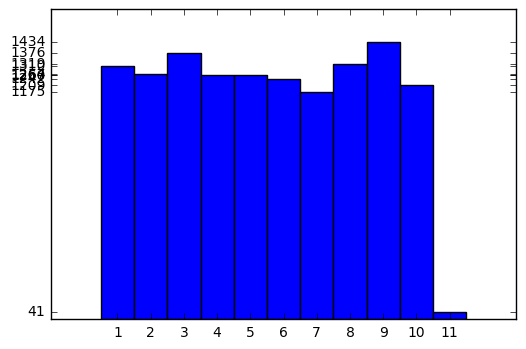

In [869]:
labels, ys = zip(*bars)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys)

### ¿Cuántos puntos ha metido UTAH JAZZ?

In [870]:
liga_data_split = liga_data.filter(lambda x : "PTS" not in x).filter(lambda x : "Playoffs" not in x).map(lambda x : x.split(":"))

In [871]:
liga_data_utah = liga_data_split.filter(lambda x: "Utah" in x[3]).map(lambda x: int(x[4])).sum()
liga_data_utah

41635

### ¿Cuántos puntos metió cada equipo como visitante?
- map reduce
- SQL

In [872]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [873]:
from pyspark.sql import Row

row_data = liga_data_split.map(lambda p: Row(
    visitor=p[3], 
    visit_points=int(p[4]),
    )
)

In [874]:
row_data.take(10)

[Row(visit_points=117, visitor='Utah Jazz'),
 Row(visit_points=95, visitor='Houston Rockets'),
 Row(visit_points=97, visitor='Portland Trail Blazers'),
 Row(visit_points=92, visitor='Dallas Mavericks'),
 Row(visit_points=103, visitor='Seattle SuperSonics'),
 Row(visit_points=110, visitor='Washington Wizards'),
 Row(visit_points=104, visitor='San Antonio Spurs'),
 Row(visit_points=103, visitor='Chicago Bulls'),
 Row(visit_points=90, visitor='Sacramento Kings'),
 Row(visit_points=83, visitor='Milwaukee Bucks')]

In [875]:
row_data.take(1)[0][0], row_data.take(1)[0][1]

(117, 'Utah Jazz')

In [876]:
def mes(x):
    x = re.search('\D+',x) 
    if x =="":
        return 0
    else:
        return(x.group().strip()[-3:])
mes('Tue, Oct 30, 2007')

'Oct'

In [877]:
matches_data = liga_data_split.map(lambda p: Row(
    year = p[0][-4:],
    mnth = mes(p[0]),
    visitor = p[3], 
    visit_points = int(p[4]),
    home =  p[5],
    home_points = int(p[6])
    )
)

In [878]:
matches = sqlContext.createDataFrame(matches_data)
matches.registerTempTable("matches")

## 5. Media de la diferencia de puntos por año

- Entiendo por diferencia de puntos por año la media (por año) de los puntos que el local anotó sobre los que anotó el visitante

In [879]:
def years(x):
    x = re.sub('[^0-9]',"",x) 
    if x =="":
        return 0
    else:
        return int(x[-4:])
parsed_def.map(lambda line: years(line[0])).distinct().collect()

[2016, 2017, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

In [880]:
parsed_def.map(lambda line: (years(line[0]), line[3], line[-1])).take(5)

[(2007, '117', '96'),
 (2007, '95', '93'),
 (2007, '97', '106'),
 (2007, '92', '74'),
 (2007, '103', '120')]

In [881]:
npart = parsed_def.map(lambda line: (years(line[0]), 1)).reduceByKey(lambda a, b: a + b)
npart.collect()

[(2016, 1333),
 (2017, 803),
 (2007, 456),
 (2008, 1332),
 (2009, 1316),
 (2010, 1321),
 (2011, 885),
 (2012, 1474),
 (2013, 1324),
 (2014, 1334),
 (2015, 1319)]

In [882]:
difpart = parsed_def.map(lambda line: (years(line[0]), int(line[-1]) - int(line[3]))).reduceByKey(lambda a, b: a + b)
difpart.collect()

[(2016, 4245),
 (2017, 2580),
 (2007, 1244),
 (2008, 4698),
 (2009, 4775),
 (2010, 3876),
 (2011, 2705),
 (2012, 4586),
 (2013, 3679),
 (2014, 3467),
 (2015, 3388)]

In [883]:
difpart.join(npart).collect()

[(2016, (4245, 1333)),
 (2017, (2580, 803)),
 (2007, (1244, 456)),
 (2008, (4698, 1332)),
 (2009, (4775, 1316)),
 (2010, (3876, 1321)),
 (2011, (2705, 885)),
 (2012, (4586, 1474)),
 (2013, (3679, 1324)),
 (2014, (3467, 1334)),
 (2015, (3388, 1319))]

* __Respuesta:__ 

In [884]:
difpart.join(npart).map(lambda line: (line[0], line[1][0]/line[1][1])).collect()

[(2016, 3.1845461365341334),
 (2017, 3.2129514321295143),
 (2007, 2.7280701754385963),
 (2008, 3.527027027027027),
 (2009, 3.628419452887538),
 (2010, 2.9341408024224074),
 (2011, 3.056497175141243),
 (2012, 3.1112618724559025),
 (2013, 2.778700906344411),
 (2014, 2.598950524737631),
 (2015, 2.5686125852918877)]

#### Ahora con SQL

In [885]:
matches = sqlContext.createDataFrame(matches_data)
matches.registerTempTable("matches")

In [886]:
# Number of points home team per year
points_home = sqlContext.sql("""
    SELECT year as hy, SUM(home_points) as hpoints FROM matches GROUP BY year
""")
points_home.show()

+----+-------+
|  hy|hpoints|
+----+-------+
|2016| 140466|
|2012| 144525|
|2017|  86682|
|2014| 136567|
|2013| 132642|
|2009| 134169|
|2011|  88998|
|2008| 134939|
|2007|  45584|
|2015| 133927|
|2010| 134132|
+----+-------+



In [887]:
# Number of points visitit team per year
points_home = sqlContext.sql("""
    SELECT year as vy, SUM(visit_points) as vpoints FROM matches GROUP BY year
""")
points_home.show()

+----+-------+
|  vy|vpoints|
+----+-------+
|2016| 136221|
|2012| 139939|
|2017|  84102|
|2014| 133100|
|2013| 128963|
|2009| 129394|
|2011|  86293|
|2008| 130241|
|2007|  44340|
|2015| 130539|
|2010| 130256|
+----+-------+



In [888]:
# Number of games team per year
games = sqlContext.sql("""
    SELECT year, COUNT(*) as games FROM matches GROUP BY year
""")
games.show()

+----+-----+
|year|games|
+----+-----+
|2016| 1333|
|2012| 1474|
|2017|  803|
|2014| 1334|
|2013| 1324|
|2009| 1316|
|2011|  885|
|2008| 1332|
|2007|  456|
|2015| 1319|
|2010| 1321|
+----+-----+



In [889]:
join_by_year = sqlContext.sql("""
    SELECT vy as y, hpoints - vpoints as difPoints
    FROM (SELECT year as vy, SUM(visit_points) as vpoints FROM matches GROUP BY year) JOIN (SELECT year as hy, SUM(home_points) as hpoints FROM matches GROUP BY year)
    ON vy = hy
""")
join_by_year.show(10)

+----+---------+
|   y|difPoints|
+----+---------+
|2016|     4245|
|2012|     4586|
|2017|     2580|
|2014|     3467|
|2013|     3679|
|2009|     4775|
|2011|     2705|
|2008|     4698|
|2007|     1244|
|2015|     3388|
+----+---------+
only showing top 10 rows



* __Respuesta:__ 

In [890]:
join_by_year_tot = sqlContext.sql("""
    SELECT vy as year, difPoints/games as meanDifPts
    FROM (SELECT year as vy, COUNT(*) as games FROM matches GROUP BY year) JOIN (SELECT vy as y, hpoints - vpoints as difPoints
    FROM (SELECT year as vy, SUM(visit_points) as vpoints FROM matches GROUP BY year) JOIN (SELECT year as hy, SUM(home_points) as hpoints FROM matches GROUP BY year)
    ON vy = hy)
    ON vy = y
""")
join_by_year_tot.show(10)

+----+------------------+
|year|        meanDifPts|
+----+------------------+
|2016|3.1845461365341334|
|2012|3.1112618724559025|
|2017|3.2129514321295143|
|2014| 2.598950524737631|
|2013| 2.778700906344411|
|2009| 3.628419452887538|
|2011| 3.056497175141243|
|2008| 3.527027027027027|
|2007|2.7280701754385963|
|2015|2.5686125852918877|
+----+------------------+
only showing top 10 rows



## 6. ¿Han jugado todos los equipos el mismo número de partidos? ¿ Si es qué no a que puede deberse?

In [891]:
visita = parsed_def.map(lambda line: (str(line[2]),1)).reduceByKey(lambda a, b: a + b)
visita.collect()

[('New Orleans Pelicans', 166),
 ('Sacramento Kings', 402),
 ('Charlotte Hornets', 127),
 ('Phoenix Suns', 413),
 ('San Antonio Spurs', 466),
 ('Miami Heat', 456),
 ('Golden State Warriors', 440),
 ('Brooklyn Nets', 218),
 ('Milwaukee Bucks', 414),
 ('New Jersey Nets', 197),
 ('Seattle SuperSonics', 41),
 ('Utah Jazz', 424),
 ('Los Angeles Lakers', 447),
 ('Indiana Pacers', 434),
 ('Houston Rockets', 434),
 ('Dallas Mavericks', 436),
 ('Oklahoma City Thunder', 408),
 ('Washington Wizards', 423),
 ('Cleveland Cavaliers', 452),
 ('Chicago Bulls', 437),
 ('Toronto Raptors', 424),
 ('Portland Trail Blazers', 428),
 ('New Orleans Hornets', 249),
 ('Memphis Grizzlies', 434),
 ('Denver Nuggets', 424),
 ('Philadelphia 76ers', 418),
 ('New York Knicks', 413),
 ('Orlando Magic', 432),
 ('Boston Celtics', 463),
 ('Atlanta Hawks', 448),
 ('Detroit Pistons', 414),
 ('Minnesota Timberwolves', 402),
 ('Charlotte Bobcats', 283),
 ('Los Angeles Clippers', 430)]

In [892]:
home = parsed_def.map(lambda line: (str(line[-2]),1)).reduceByKey(lambda a, b: a + b)
home.collect()

[('New Orleans Pelicans', 166),
 ('Sacramento Kings', 402),
 ('Atlanta Hawks', 448),
 ('Charlotte Hornets', 126),
 ('Phoenix Suns', 412),
 ('San Antonio Spurs', 467),
 ('Golden State Warriors', 445),
 ('Brooklyn Nets', 217),
 ('Toronto Raptors', 426),
 ('New Jersey Nets', 197),
 ('Boston Celtics', 467),
 ('Utah Jazz', 422),
 ('Los Angeles Lakers', 450),
 ('Miami Heat', 461),
 ('Houston Rockets', 434),
 ('Dallas Mavericks', 431),
 ('Oklahoma City Thunder', 410),
 ('Washington Wizards', 421),
 ('Cleveland Cavaliers', 449),
 ('Chicago Bulls', 436),
 ('Milwaukee Bucks', 413),
 ('New Orleans Hornets', 250),
 ('Seattle SuperSonics', 41),
 ('Denver Nuggets', 424),
 ('Detroit Pistons', 415),
 ('Philadelphia 76ers', 416),
 ('New York Knicks', 412),
 ('Orlando Magic', 431),
 ('Indiana Pacers', 434),
 ('Charlotte Bobcats', 283),
 ('Portland Trail Blazers', 425),
 ('Minnesota Timberwolves', 402),
 ('Memphis Grizzlies', 433),
 ('Los Angeles Clippers', 431)]

In [893]:
home.join(visita).map(lambda linea : (linea[0], linea[1][0] + linea[1][1])).collect()

[('New Orleans Pelicans', 332),
 ('Atlanta Hawks', 896),
 ('Charlotte Hornets', 253),
 ('Phoenix Suns', 825),
 ('Utah Jazz', 846),
 ('Golden State Warriors', 885),
 ('Brooklyn Nets', 435),
 ('Milwaukee Bucks', 827),
 ('New Jersey Nets', 394),
 ('Boston Celtics', 930),
 ('Toronto Raptors', 850),
 ('Houston Rockets', 868),
 ('Los Angeles Lakers', 897),
 ('Miami Heat', 917),
 ('San Antonio Spurs', 933),
 ('Dallas Mavericks', 867),
 ('Oklahoma City Thunder', 818),
 ('Washington Wizards', 844),
 ('Cleveland Cavaliers', 901),
 ('Chicago Bulls', 873),
 ('Denver Nuggets', 848),
 ('New Orleans Hornets', 499),
 ('Memphis Grizzlies', 867),
 ('Sacramento Kings', 804),
 ('Detroit Pistons', 829),
 ('Philadelphia 76ers', 834),
 ('New York Knicks', 825),
 ('Orlando Magic', 863),
 ('Indiana Pacers', 868),
 ('Charlotte Bobcats', 566),
 ('Portland Trail Blazers', 853),
 ('Minnesota Timberwolves', 804),
 ('Seattle SuperSonics', 82),
 ('Los Angeles Clippers', 861)]

In [894]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [895]:
visitor = sqlContext.createDataFrame(row_data)
visitor.registerTempTable("visitor_table")

In [896]:
matches = sqlContext.createDataFrame(matches_data)
matches.registerTempTable("matches")

In [897]:
# Number of distinct teams in data set
number_of_teams = sqlContext.sql("""
    SELECT COUNT(DISTINCT visitor) FROM visitor_table
""")
number_of_teams.show()

+-----------------------+
|count(DISTINCT visitor)|
+-----------------------+
|                     34|
+-----------------------+



In [898]:
# Number games for visitor teams
visits_by_teams = sqlContext.sql("""
    SELECT visitor, count(*) FROM visitor_table GROUP BY visitor
""")
visits_by_teams.show()

+--------------------+--------+
|             visitor|count(1)|
+--------------------+--------+
|        Phoenix Suns|     413|
|      Boston Celtics|     463|
|    Dallas Mavericks|     436|
|New Orleans Pelicans|     166|
|       Brooklyn Nets|     218|
|     New York Knicks|     413|
| New Orleans Hornets|     249|
|Minnesota Timberw...|     402|
|   Memphis Grizzlies|     434|
|  Los Angeles Lakers|     447|
|Golden State Warr...|     440|
|       Orlando Magic|     432|
|   Charlotte Bobcats|     283|
|Los Angeles Clippers|     430|
|     Detroit Pistons|     414|
|       Chicago Bulls|     437|
|     Milwaukee Bucks|     414|
| Cleveland Cavaliers|     452|
|      Indiana Pacers|     434|
|  Washington Wizards|     423|
+--------------------+--------+
only showing top 20 rows



In [899]:
visits_by_teams = sqlContext.sql("""
    SELECT home, count(*) FROM matches GROUP BY home
""")
visits_by_teams.show()

+--------------------+--------+
|                home|count(1)|
+--------------------+--------+
|        Phoenix Suns|     412|
|      Boston Celtics|     467|
|    Dallas Mavericks|     431|
|New Orleans Pelicans|     166|
|       Brooklyn Nets|     217|
|     New York Knicks|     412|
| New Orleans Hornets|     250|
|   Memphis Grizzlies|     433|
|Minnesota Timberw...|     402|
|  Los Angeles Lakers|     450|
|Golden State Warr...|     445|
|       Orlando Magic|     431|
|   Charlotte Bobcats|     283|
|Los Angeles Clippers|     431|
|     Detroit Pistons|     415|
|       Chicago Bulls|     436|
|     Milwaukee Bucks|     413|
| Cleveland Cavaliers|     449|
|      Indiana Pacers|     434|
|  Washington Wizards|     421|
+--------------------+--------+
only showing top 20 rows



* __Respuesta:__ No, debe ser por la diferencia en juegos por serie y playoffs

In [900]:
join_by_teams = sqlContext.sql("""
    SELECT home, pHome + pVisit
    FROM (SELECT home, count(*) as pHome FROM matches GROUP BY home) JOIN (SELECT visitor, count(*) as pVisit FROM visitor_table GROUP BY visitor)
    ON home = visitor
""")
join_by_teams.show(10)

+--------------------+----------------+
|                home|(pHome + pVisit)|
+--------------------+----------------+
|        Phoenix Suns|             825|
|      Boston Celtics|             930|
|    Dallas Mavericks|             867|
|New Orleans Pelicans|             332|
|       Brooklyn Nets|             435|
|     New York Knicks|             825|
| New Orleans Hornets|             499|
|   Memphis Grizzlies|             867|
|Minnesota Timberw...|             804|
|  Los Angeles Lakers|             897|
+--------------------+----------------+
only showing top 10 rows



## 7. ¿Cuantos partidos ha ganado en Enero Cleveland?

In [901]:
cleveland_visit_wins = liga_data_split.filter(lambda x: "Cleveland" in x[3]).filter(lambda x: int(x[4])>int(x[6])).filter(lambda x: "Jan" in x[0])
cleveland_home_wins = liga_data_split.filter(lambda x: "Cleveland" in x[5]).filter(lambda x: int(x[4])<int(x[6])).filter(lambda x: "Jan" in x[0])

In [902]:
cleveland_visit_wins.count() + cleveland_home_wins.count()

83

In [903]:
Cleveland_home = sqlContext.sql("""
    SELECT COUNT(home) FROM matches WHERE mnth = "Jan" AND home = "Cleveland Cavaliers" AND home_points > visit_points
""")
Cleveland_home.show()

+-----------+
|count(home)|
+-----------+
|         42|
+-----------+



In [904]:
Cleveland_visit = sqlContext.sql("""
    SELECT COUNT(visitor) FROM matches WHERE mnth = "Jan" AND visitor = "Cleveland Cavaliers" AND home_points < visit_points
""")
Cleveland_visit.show()

+--------------+
|count(visitor)|
+--------------+
|            41|
+--------------+



In [905]:
Cleveland_Jan_W = sqlContext.sql("""
    SELECT count(home) FROM matches WHERE visitor = "Cleveland Cavaliers" AND mnth = "Jan" AND home_points < visit_points
    OR home = "Cleveland Cavaliers" AND mnth = "Jan" AND home_points > visit_points
""")
Cleveland_Jan_W.show()

+-----------+
|count(home)|
+-----------+
|         83|
+-----------+



* __Respuesta:__ 83 victorias en enero para los cavs

## 8. ¿Los Warrios son mejores fuera de casa o en casa?

In [906]:
## away
liga_data_split.filter(lambda x: "Golden State Warriors" in x[3]).filter(lambda x: int(x[4])>int(x[6])).count()

215

In [907]:
## home
liga_data_split.filter(lambda x: "Golden State Warriors" in x[5]).filter(lambda x: int(x[4])<int(x[6])).count()

308

In [908]:
Warriors_home = sqlContext.sql("""
    SELECT COUNT(home) FROM matches WHERE home = "Golden State Warriors" AND home_points > visit_points
""")
Warriors_home.show()

+-----------+
|count(home)|
+-----------+
|        308|
+-----------+



In [909]:
Warriors_visit = sqlContext.sql("""
    SELECT COUNT(visitor) FROM matches WHERE visitor = "Golden State Warriors" AND home_points < visit_points
""")
Warriors_visit.show()

+--------------+
|count(visitor)|
+--------------+
|           215|
+--------------+



* __Respuesta:__ Los warriors son mejores en casa

## 9. Equipo que ha quedado primerio en victorias más temporadas. (si es que hay alguno que más)

In [910]:
# Create new variable: winner of the match.
# Count
def winner(line):
    if line[3] > line[5]:
        return (str(years(line[0]))+(line[2]), 1)
    elif line[3] < line[5]:
        return (str(years(line[0]))+(line[4]), 1)
    


In [911]:
parsed_def.map(lambda line: winner(line)).take(5)

[('2007Golden State Warriors', 1),
 ('2007Houston Rockets', 1),
 ('2007Portland Trail Blazers', 1),
 ('2007Dallas Mavericks', 1),
 ('2007Denver Nuggets', 1)]

In [912]:
parsed_def.map(lambda line: winner(line)).map(lambda line: (str(line[-2]),1)).reduceByKey(lambda a, b: a + b).sortBy(lambda line :line[1], ascending =False).take(5)

[('2010Boston Celtics', 62),
 ('2016Golden State Warriors', 62),
 ('2008Boston Celtics', 60),
 ('2012Los Angeles Lakers', 59),
 ('2015Houston Rockets', 59)]

In [913]:
# Create new variable: winner of the match.
# Count
def winner2(line):
    if line[3] > line[5]:
        return (str(years(line[0])),(line[2]))
    elif line[3] < line[5]:
        return (str(years(line[0])),(line[4]))
    


In [919]:
tabla1 = parsed_def.map(lambda line: winner2(line)).map(lambda line: ((line),1)).reduceByKey(lambda a, b: a + b).reduceByKey(max)
tabla1.take(5)

[(('2013', 'Los Angeles Clippers'), 44),
 (('2013', 'Indiana Pacers'), 52),
 (('2012', 'Minnesota Timberwolves'), 49),
 (('2007', 'Atlanta Hawks'), 17),
 (('2013', 'Sacramento Kings'), 34)]

In [939]:
parsed_def.map(lambda line: winner2(line)).map(lambda line: ((line),1)).reduceByKey(lambda a, b: a + b).map(lambda linea:(linea[0][0],linea[1])).reduceByKey(max).collect()

[('2017', 43),
 ('2013', 57),
 ('2011', 40),
 ('2016', 62),
 ('2014', 56),
 ('2008', 60),
 ('2007', 19),
 ('2015', 59),
 ('2009', 56),
 ('2010', 62),
 ('2012', 59)]

In [934]:
tabla2 = parsed_def.map(lambda line: winner2(line)).map(lambda line: ((line),1)).reduceByKey(lambda a, b: a + b).map(lambda linea:(linea[0][0],linea[1])).reduceByKey(max).map(lambda line:(line,""))
tabla2.collect()

[(('2017', 43), ''),
 (('2013', 57), ''),
 (('2011', 40), ''),
 (('2016', 62), ''),
 (('2014', 56), ''),
 (('2008', 60), ''),
 (('2007', 19), ''),
 (('2015', 59), ''),
 (('2009', 56), ''),
 (('2010', 62), ''),
 (('2012', 59), '')]

In [925]:
tabla1 = tabla1.map(lambda line: ((line[0][0],line[1]), line[0][1]))
tabla1.take(5)

[(('2013', 44), 'Los Angeles Clippers'),
 (('2013', 52), 'Indiana Pacers'),
 (('2012', 49), 'Minnesota Timberwolves'),
 (('2007', 17), 'Atlanta Hawks'),
 (('2013', 34), 'Sacramento Kings')]

In [937]:
tabla1.join(tabla2).collect()

[(('2010', 62), ('Boston Celtics', '')),
 (('2016', 62), ('Golden State Warriors', '')),
 (('2014', 56), ('Indiana Pacers', '')),
 (('2011', 40), ('Chicago Bulls', '')),
 (('2009', 56), ('Orlando Magic', '')),
 (('2013', 57), ('Memphis Grizzlies', '')),
 (('2007', 19), ('Cleveland Cavaliers', '')),
 (('2007', 19), ('Portland Trail Blazers', '')),
 (('2007', 19), ('Milwaukee Bucks', '')),
 (('2017', 43), ('Cleveland Cavaliers', '')),
 (('2012', 59), ('Los Angeles Lakers', '')),
 (('2008', 60), ('Boston Celtics', '')),
 (('2015', 59), ('Houston Rockets', ''))]

* __Respuesta:__ Ninguno

In [916]:
primero_temporadas = sqlContext.sql("""
    SELECT year, IF(home_points > visit_points, home, visitor) as winner FROM matches 
""")
primero_temporadas.show()

+----+-------------------+
|year|             winner|
+----+-------------------+
|2007|          Utah Jazz|
|2007|    Houston Rockets|
|2007|  San Antonio Spurs|
|2007|   Dallas Mavericks|
|2007|     Denver Nuggets|
|2007|     Indiana Pacers|
|2007|  San Antonio Spurs|
|2007|    New Jersey Nets|
|2007|New Orleans Hornets|
|2007|      Orlando Magic|
|2007|    Toronto Raptors|
|2007|    Detroit Pistons|
|2007|       Phoenix Suns|
|2007|    Houston Rockets|
|2007|      Atlanta Hawks|
|2007|     Boston Celtics|
|2007|  Charlotte Bobcats|
|2007| Philadelphia 76ers|
|2007|Cleveland Cavaliers|
|2007|     Indiana Pacers|
+----+-------------------+
only showing top 20 rows



## 10. Escribe la expresión regular correcta que sólo macheen los teléfonos y el correo del siguiente texto.

In [461]:
texto = 'Si eres cliente y necesitas información sobre tus posiciones, productos o realizar operaciones: Desde España. Desde el extranjero. Banca telefónica en castellano. Bandera castellano. 902 13 23 13. Banca telefónica en catalán. Bandera catalana. 902 88 30 08. Banca telefónica en inglés. Bandera inglesa. 902 88 88 35. O por correo electrónico a atencioncliente@bankinter.com'

In [462]:
telefono = '(\d+\s\d+\s\d+\s\d+)'
mail = '(\S+[@]\S+)'

In [463]:
re.findall(telefono,texto)

['902 13 23 13', '902 88 30 08', '902 88 88 35']

In [464]:
re.search(mail, texto)

<_sre.SRE_Match object; span=(344, 373), match='atencioncliente@bankinter.com'>

In [465]:
re.findall(telefono+mail, texto)

[]

Siempre al final:

In [836]:
sc.stop()